# Packages and libraries to install
Only uncomment if you havent installed these before

In [79]:
#pip install nltk

In [78]:
#pip install pdfplumber

In [80]:
# Import libraries for data manipulation and analysis
import pandas as pd
import numpy as np

# Import libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker')
nltk.download('maxent_ne_chunker_tab')
nltk.download('words')
nltk.download('vader_lexicon')

# Import libraries for downloading and handling files
import requests
from pathlib import Path
import io

# Import library for PDF text extraction
from pypdf import PdfReader

# Import libraries for text processing
import re
from collections import Counter

# Import libraries for FinBERT transformer model
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pdfplumber

# Set visualization style preferences
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     C:\Users\hp\AppData\

## Sentiment Analysis for Big 5 Banks

In this notebook we will address Use Case 3 of our capstone project using two different techniques:

1. VADER (Valence Aware Dictionarty and Sentiment Reasoner) - Bag of words approach
2. Roberta Pretained Model from Hugging Face - Advanced Transformer Model

# Step 0. Read in Data and converting it into a Table for processing

In [2]:
banks_to_analyze = [
    {
        'name': 'Scotiabank',
        'url': 'https://www.scotiabank.com/content/dam/scotiabank/corporate/quarterly-reports/2025/q1/BNS-T_Transcript_2025-02-25.pdf'
    },
    {
        'name': 'RBC',
        'url': 'https://www.rbc.com/investor-relations/_assets-custom/pdf/2025q1speech.pdf'
    },
    {
        'name': 'TD Bank',
        'url': 'https://www.td.com/content/dam/tdcom/canada/about-td/pdf/quarterly-results/2025/q1/2025-q1-td-transcript.pdf'
    }
]

print(f"Configured {len(banks_to_analyze)} banks for analysis")

Configured 3 banks for analysis


In [3]:
def parse_year_quarter(url: str):
    """
    This function looks at the PDF URL and tries to extract:
    - the year (e.g. 2025)
    - the quarter (e.g. Q1)

    We do this because most bank transcript URLs include this info.
    """

    # Case 1: URLs like ".../2025/q1/..."
    m1 = re.search(r"/(20\d{2})/q([1-4])/", url.lower())
    if m1:
        return int(m1.group(1)), f"Q{m1.group(2)}"

    # Case 2: URLs like "...2025q1..." or "...2025-q1..."
    cleaned = url.lower().replace("-", "").replace("_", "")
    m2 = re.search(r"(20\d{2})q([1-4])", cleaned)
    if m2:
        return int(m2.group(1)), f"Q{m2.group(2)}"

    # If nothing is found, we return empty values
    return None, None

#We want the final table to already know which year and quarter each page belongs to, instead of adding that information manually later.

In [4]:
def chunk_text(text, max_tokens=512):
    """
    This function splits a long text into smaller chunks.
    Each chunk has at most `max_tokens` words.

    We do this to avoid transformer token limit errors.
    """

    words = text.split()
    chunks = []

    for i in range(0, len(words), max_tokens):
        chunk = " ".join(words[i:i + max_tokens])
        chunks.append(chunk)

    return chunks


In [5]:
rows = []

for bank in banks_to_analyze:
    bank_name = bank["name"]
    url = bank["url"]

    # Extract year and quarter from the URL
    year, quarter = parse_year_quarter(url)

    # Download the PDF
    pdf_bytes = requests.get(url, timeout=60).content

    # Open the PDF and read page by page
    with pdfplumber.open(io.BytesIO(pdf_bytes)) as pdf:
        for page_number, page in enumerate(pdf.pages, start=1):
            raw_text = page.extract_text() or ""
            raw_text = raw_text.replace("\x00", "").strip()

            # Split the page into 512-token chunks
            text_chunks = chunk_text(raw_text, max_tokens=512)

            # Store each chunk as its own row
            for chunk in text_chunks:
                rows.append({
                    "Bank": bank_name,
                    "Year": year,
                    "Quarter": quarter,
                    "Page": page_number,
                    "Text": chunk
                })


In [54]:
df_pages = pd.DataFrame(rows)
df_pages["row_num"] = range(1, len(df_pages) + 1)
df_pages["row_id"] = (
    df_pages["row_num"].astype(str) + "_" +
    df_pages["Bank"] + "_" +
    df_pages["Year"].astype(str) +
    df_pages["Quarter"] + "_P" +
    df_pages["Page"].astype(str)
)

cols = ["row_id", "row_num"] + [c for c in df_pages.columns if c not in ["row_id", "row_num"]]
df_pages = df_pages[cols]


df_pages.head(30)


,row_id,row_num,Bank,Year,Quarter,Page,Text
0,1_Scotiabank_2025Q1_P1,1,Scotiabank,2025,Q1,1,SCOTIABANK Q1 2025 EARNINGS CONFERENCE CALL Fe...
1,2_Scotiabank_2025Q1_P1,2,Scotiabank,2025,Q1,1,and market conditions in the countries in whic...
2,3_Scotiabank_2025Q1_P1,3,Scotiabank,2025,Q1,1,"results, businesses, financial condition or li..."
3,4_Scotiabank_2025Q1_P2,4,Scotiabank,2025,Q1,2,CORPORATE PARTICIPANTS Scott Thomson The Bank ...
4,5_Scotiabank_2025Q1_P3,5,Scotiabank,2025,Q1,3,Scott Thomson - The Bank of Nova Scotia – Pres...
5,6_Scotiabank_2025Q1_P3,6,Scotiabank,2025,Q1,3,"now have a Scotiabank payment product, up 50 b..."
6,7_Scotiabank_2025Q1_P4,7,Scotiabank,2025,Q1,4,Turning to a few key performance metrics and s...
7,8_Scotiabank_2025Q1_P4,8,Scotiabank,2025,Q1,4,provisions because of portfolio migration and ...
8,9_Scotiabank_2025Q1_P5,9,Scotiabank,2025,Q1,5,we saw primary client expansion with deposits ...
9,10_Scotiabank_2025Q1_P5,10,Scotiabank,2025,Q1,5,now turn it to Raj for a more detailed financi...


## Quick EDA

In [55]:
df_pages['Text'].values[0]

'SCOTIABANK Q1 2025 EARNINGS CONFERENCE CALL February 25, 2025 DISCLAIMER THIS TRANSCRIPT HAS BEEN FURNISHED FOR YOUR INFORMATION ONLY, IS CURRENT ONLY AS OF THE DATE OF THE CONFERENCE CALL, AND MAY BE SUPERSEDED BY MORE INFORMATION. EXCEPT AS REQUIRED BY LAW, THE BANK OF NOVA SCOTIA (“BNS”) DOES NOT UNDERTAKE ANY OBLIGATION TO UPDATE THE INFORMATION, WHETHER AS A RESULT OF NEW INFORMATION, FUTURE EVENTS OR OTHERWISE. THE INFORMATION CONTAINED IN THIS TRANSCRIPT IS A TEXTUAL REPRESENTATION OF BNS Q1 2025 EARNINGS CONFERENCE CALL AND WHILE EFFORTS ARE MADE TO PROVIDE AN ACCURATE TRANSCRIPTION, THERE MAY BE MATERIAL ERRORS, OMISSIONS, OR INACCURACIES IN THE REPORTING OF THE SUBSTANCE OF THE CONFERENCE CALL. IN NO WAY DOES BNS ASSUME ANY RESPONSIBILITY FOR ANY INVESTMENT OR OTHER DECISIONS MADE BASED UPON THE INFORMATION PROVIDED ON BNS’ WEBSITE OR IN THIS TRANSCRIPT. USERS ARE ADVISED TO REVIEW THE WEBCAST (AVAILABLE AT SCOTIABANK.COM/CA/EN/ABOUT/INVESTORS-SHAREHOLDERS/FINANCIAL-RESULT.H

In [56]:
df_pages['Page'].value_counts()#.sort_index().plot(kind='bar',title='Count of pages by review',figsize=(10,5))
# tells us how many chunks of text came from each PDF page

Page
1     8
3     6
4     6
6     6
5     6
7     6
8     6
9     5
2     4
10    4
11    4
12    4
13    4
14    3
15    1
Name: count, dtype: int64

## Basic NLTK

In [57]:
example = df_pages['Text'][67]
print(example)

at the same time. We're seeing really promising results. So referrals from our branch to our MMS have tripled quarter-over-quarter (sic) year-over-year. It's translating into real dollars. We've delivered $1 billion in funded volumes through that channel alone and it's been the best Q1 on record for MMS. So back to your question. Now overall growth will vary from quarter-to-quarter, but the fundamentals are absolutely pointed in the right direction. I think you typically see some seasonality that's lower in Q1 but ultimately, this is a good book. We compete to win profitable business. We're seeing really good results in our proprietary channels. We're also seeing depth of relationship improve up nicely year-over-year among our RESL customers. So I'd probably sum up by saying our aspirations are declarative, they're bold, we like the strength that we're seeing in our proprietary ecosystem, and we're going to continue to compete to win profitable business. Matthew Lee – Canaccord Genuity

In [58]:
tokens = nltk.word_tokenize(example)
tokens[:35]

['at',
 'the',
 'same',
 'time',
 '.',
 'We',
 "'re",
 'seeing',
 'really',
 'promising',
 'results',
 '.',
 'So',
 'referrals',
 'from',
 'our',
 'branch',
 'to',
 'our',
 'MMS',
 'have',
 'tripled',
 'quarter-over-quarter',
 '(',
 'sic',
 ')',
 'year-over-year',
 '.',
 'It',
 "'s",
 'translating',
 'into',
 'real',
 'dollars',
 '.']

In [11]:
tagged = nltk.pos_tag(tokens)
tagged[:12]

[('at', 'IN'),
 ('the', 'DT'),
 ('same', 'JJ'),
 ('time', 'NN'),
 ('.', '.'),
 ('We', 'PRP'),
 ("'re", 'VBP'),
 ('seeing', 'VBG'),
 ('really', 'RB'),
 ('promising', 'JJ'),
 ('results', 'NNS'),
 ('.', '.')]

In [12]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  at/IN
  the/DT
  same/JJ
  time/NN
  ./.
  We/PRP
  're/VBP
  seeing/VBG
  really/RB
  promising/JJ
  results/NNS
  ./.
  So/JJ
  referrals/NNS
  from/IN
  our/PRP$
  branch/NN
  to/TO
  our/PRP$
  MMS/NNP
  have/VBP
  tripled/VBN
  quarter-over-quarter/NN
  (/(
  sic/JJ
  )/)
  year-over-year/NN
  ./.
  It/PRP
  's/VBZ
  translating/VBG
  into/IN
  real/JJ
  dollars/NNS
  ./.
  We/PRP
  've/VBP
  delivered/VBN
  $/$
  1/CD
  billion/CD
  in/IN
  funded/JJ
  volumes/NNS
  through/IN
  that/DT
  channel/NN
  alone/RB
  and/CC
  it/PRP
  's/VBZ
  been/VBN
  the/DT
  best/JJS
  Q1/NN
  on/IN
  record/NN
  for/IN
  (ORGANIZATION MMS/NNP)
  ./.
  So/RB
  back/RB
  to/TO
  your/PRP$
  question/NN
  ./.
  Now/RB
  overall/JJ
  growth/NN
  will/MD
  vary/VB
  from/IN
  quarter-to-quarter/NN
  ,/,
  but/CC
  the/DT
  fundamentals/NNS
  are/VBP
  absolutely/RB
  pointed/VBN
  in/IN
  the/DT
  right/JJ
  direction/NN
  ./.
  I/PRP
  think/VBP
  you/PRP
  typically/RB
  see/VB
  some/DT
  sea

# Step 1. VADER Sentiment Scoring

We will use NLTKs SentimentIntensityAnalyzer to get the negative/neutral/positive scores of the text. Takes all the words of the sentence and has a values of positive/neutral/negative and adds up for all the words.

We remove stop words "and", "the", "because".
Each word is combined and scored individually

In [45]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [46]:
sia.polarity_scores('I am so happy!')

#example positive

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [47]:
sia.polarity_scores('I hate this food')
# example negative

{'neg': 0.649, 'neu': 0.351, 'pos': 0.0, 'compound': -0.5719}

In [48]:
sia.polarity_scores('the event is tomorrow')
#example neutral

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [49]:
example2 = example[18:55]
example2

"We're seeing really promising results"

In [50]:
sia.polarity_scores(example2)

{'neg': 0.0, 'neu': 0.572, 'pos': 0.428, 'compound': 0.4576}

We want to run this polarity score on the entire dataset

In [60]:
res = {}
for i,row in tqdm(df_pages.iterrows(),total=len(df_pages)):
    text = row['Text']
    myid = row['row_id']
    res[myid]=sia.polarity_scores(text)

  0%|          | 0/73 [00:00<?, ?it/s]

In [62]:
# provides a dictionary with the results
res

{'1_Scotiabank_2025Q1_P1': {'neg': 0.041,
  'neu': 0.922,
  'pos': 0.036,
  'compound': -0.7082},
 '2_Scotiabank_2025Q1_P1': {'neg': 0.107,
  'neu': 0.797,
  'pos': 0.096,
  'compound': -0.8176},
 '3_Scotiabank_2025Q1_P1': {'neg': 0.027,
  'neu': 0.938,
  'pos': 0.035,
  'compound': 0.3068},
 '4_Scotiabank_2025Q1_P2': {'neg': 0.012,
  'neu': 0.924,
  'pos': 0.063,
  'compound': 0.946},
 '5_Scotiabank_2025Q1_P3': {'neg': 0.021,
  'neu': 0.788,
  'pos': 0.192,
  'compound': 0.9981},
 '6_Scotiabank_2025Q1_P3': {'neg': 0.0,
  'neu': 0.863,
  'pos': 0.137,
  'compound': 0.9884},
 '7_Scotiabank_2025Q1_P4': {'neg': 0.009,
  'neu': 0.79,
  'pos': 0.201,
  'compound': 0.9985},
 '8_Scotiabank_2025Q1_P4': {'neg': 0.012,
  'neu': 0.791,
  'pos': 0.197,
  'compound': 0.9946},
 '9_Scotiabank_2025Q1_P5': {'neg': 0.012,
  'neu': 0.758,
  'pos': 0.23,
  'compound': 0.9987},
 '10_Scotiabank_2025Q1_P5': {'neg': 0.033,
  'neu': 0.85,
  'pos': 0.117,
  'compound': 0.984},
 '11_Scotiabank_2025Q1_P6': {'neg'

In [69]:
# we want to store in a Pandas dictionary
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index':'row_id'})
vaders = vaders.merge(df_pages, how='left')

In [71]:
#now we have sentiment score and metadata
vaders.head()

,row_id,neg,neu,pos,compound,row_num,Bank,Year,Quarter,Page,Text
0,1_Scotiabank_2025Q1_P1,0.041,0.922,0.036,-0.7082,1,Scotiabank,2025,Q1,1,SCOTIABANK Q1 2025 EARNINGS CONFERENCE CALL Fe...
1,2_Scotiabank_2025Q1_P1,0.107,0.797,0.096,-0.8176,2,Scotiabank,2025,Q1,1,and market conditions in the countries in whic...
2,3_Scotiabank_2025Q1_P1,0.027,0.938,0.035,0.3068,3,Scotiabank,2025,Q1,1,"results, businesses, financial condition or li..."
3,4_Scotiabank_2025Q1_P2,0.012,0.924,0.063,0.9460,4,Scotiabank,2025,Q1,2,CORPORATE PARTICIPANTS Scott Thomson The Bank ...
4,5_Scotiabank_2025Q1_P3,0.021,0.788,0.192,0.9981,5,Scotiabank,2025,Q1,3,Scott Thomson - The Bank of Nova Scotia – Pres...


# Plot VADER results

Text(0.5, 1.0, 'Average VADER Compound Score by Bank')

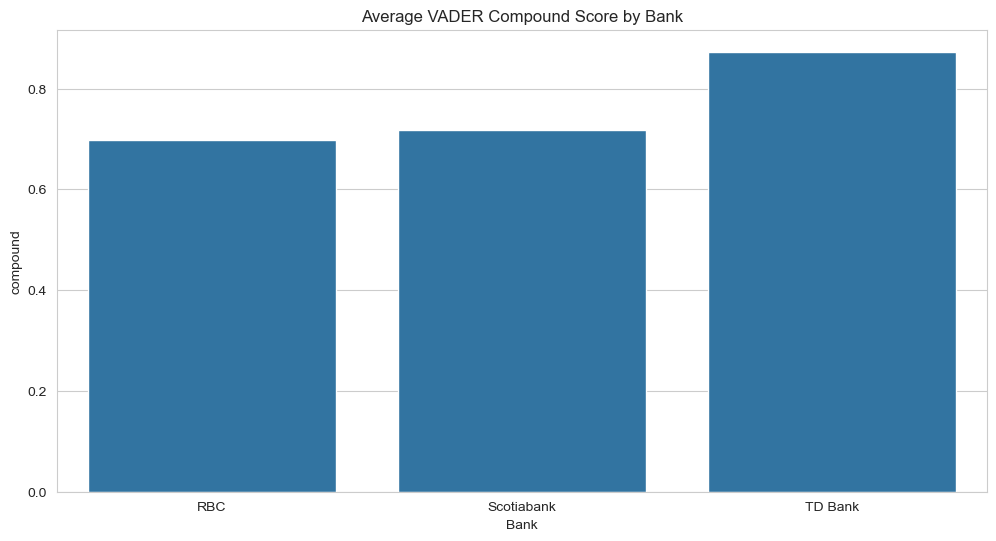

In [77]:
avg_sentiment = (
    vaders
    .groupby("Bank", as_index=False)["compound"]
    .mean()
)

sns.barplot(data=avg_sentiment, x="Bank", y="compound")
plt.title("Average VADER Compound Score by Bank")

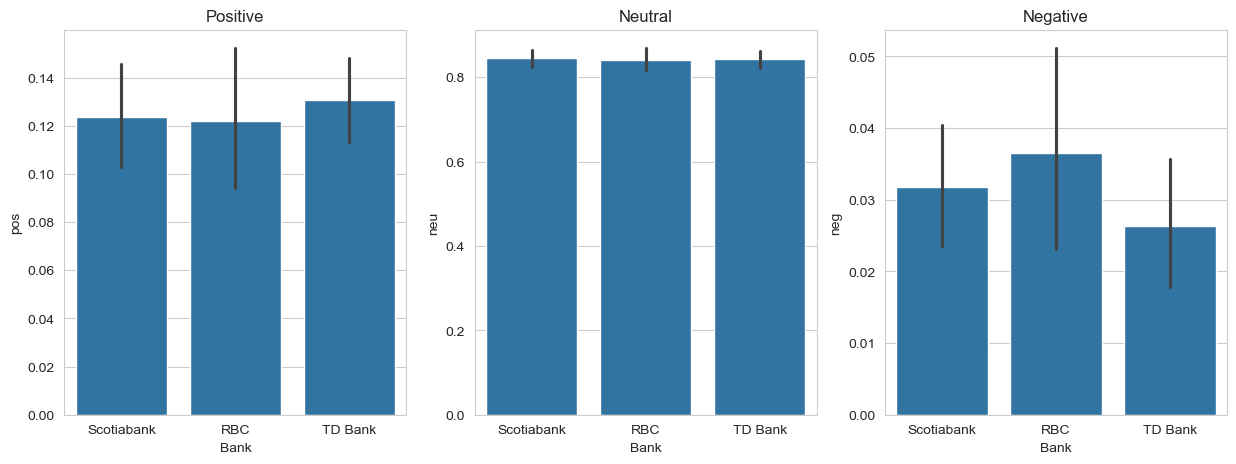

In [85]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
sns.barplot(data=vaders, x='Bank', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Bank', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Bank', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.show()

# Step 2  Roberta Pretrained Model

- Use a model trained of a large amount of data
- Understands context (i.e. "Not so bad")
- Transformer relates to the context of other words

In [89]:
#HuggingFace Library
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [91]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
import os
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

In [92]:
sia.polarity_scores(example2)

{'neg': 0.0, 'neu': 0.572, 'pos': 0.428, 'compound': 0.4576}

In [111]:
#Run for Roberta Model
encoded_text = tokenizer(example2, return_tensors='pt')
output= model(**encoded_text)

#take it from tensor format to numpy
scores=output[0][0].detach().numpy()
scores=softmax(scores)
#build a dict to gives you negative, neutral, and positive

scores_dict = {'roberta_neg': round(float(scores[0]),3), 'roberta_neu': round(float(scores[1]),3), 'roberta_pos': round(float(scores[2]),3)}

print(scores_dict)

{'roberta_neg': 0.002, 'roberta_neu': 0.032, 'roberta_pos': 0.966}


In [118]:
def polarity_scores_roberta(example):
    #Run for Roberta Model
    encoded_text = tokenizer(example2, return_tensors='pt')
    output= model(**encoded_text)
    
    #take it from tensor format to numpy
    scores=output[0][0].detach().numpy()
    scores=softmax(scores)
    #build a dict to gives you negative, neutral, and positive
    
    scores_dict = {'roberta_neg': round(float(scores[0]),3), 'roberta_neu': round(float(scores[1]),3), 'roberta_pos': round(float(scores[2]),3)}
    return scores_dict

In [119]:
#Iterate over the dataset and join results of both models
res = {}
for i,row in tqdm(df_pages.iterrows(),total=len(df_pages)):
    text = row['Text']
    bank_id = row['row_id']
    vader_result=sia.polarity_scores(text)
    vader_result_rename = {}
    for key,value in vader_result.items():
        vader_result_rename[f"vader_{key}"] = value
    roberta_result = polarity_scores_roberta(text)
    both = {**vader_result_rename, **roberta_result}
    res[bank_id] = both

  0%|          | 0/73 [00:00<?, ?it/s]

In [120]:
# we want to store in a Pandas dictionary
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index':'row_id'})
results_df = results_df.merge(df_pages, how='left')

In [121]:
results_df.head()

,row_id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,row_num,Bank,Year,Quarter,Page,Text
0,1_Scotiabank_2025Q1_P1,0.041,0.922,0.036,-0.7082,0.002,0.032,0.966,1,Scotiabank,2025,Q1,1,SCOTIABANK Q1 2025 EARNINGS CONFERENCE CALL Fe...
1,2_Scotiabank_2025Q1_P1,0.107,0.797,0.096,-0.8176,0.002,0.032,0.966,2,Scotiabank,2025,Q1,1,and market conditions in the countries in whic...
2,3_Scotiabank_2025Q1_P1,0.027,0.938,0.035,0.3068,0.002,0.032,0.966,3,Scotiabank,2025,Q1,1,"results, businesses, financial condition or li..."
3,4_Scotiabank_2025Q1_P2,0.012,0.924,0.063,0.9460,0.002,0.032,0.966,4,Scotiabank,2025,Q1,2,CORPORATE PARTICIPANTS Scott Thomson The Bank ...
4,5_Scotiabank_2025Q1_P3,0.021,0.788,0.192,0.9981,0.002,0.032,0.966,5,Scotiabank,2025,Q1,3,Scott Thomson - The Bank of Nova Scotia – Pres...


## Compare Scores between models

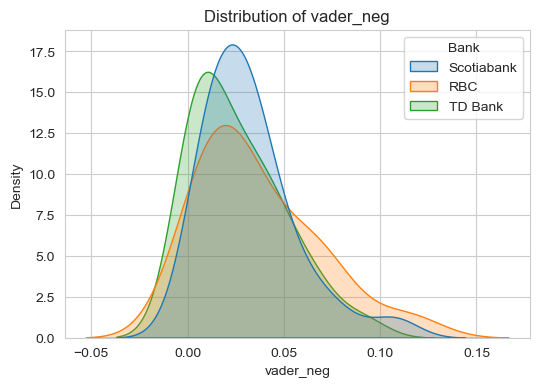

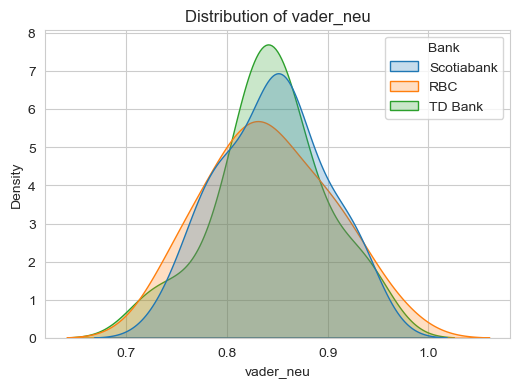

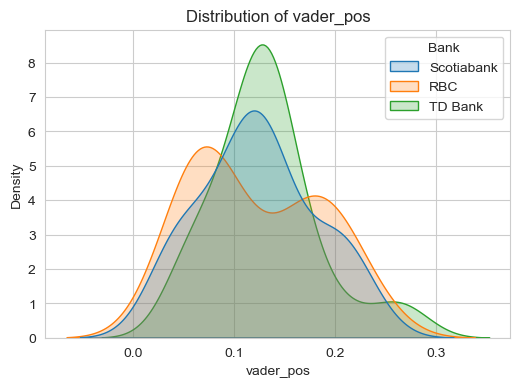

In [127]:
results_df.columns = results_df.columns.str.strip()  # safe

sentiment_cols = ["vader_neg", "vader_neu", "vader_pos"]  # add roberta_* if you want

for col in sentiment_cols:
    plt.figure(figsize=(6,4))
    sns.kdeplot(data=results_df, x=col, hue="Bank", fill=True, common_norm=False)
    plt.title(f"Distribution of {col}")
    plt.show()

# Shows how often its positive,negative,neutral
